# Introduction

This notebook serves as a tutorial for using the DESeq2 package. Please be sure to consult the excellent vignette provided by the DESeq2 package. Hopefully, we will also get a chance to review the edgeR package (which also has a very nice vignette which I suggest that you review)

# Load packages

Load requisite R packages

In [28]:
sessionInfo()
library()

R version 3.3.1 (2016-06-21)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 8 (jessie)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C               LC_TIME=en_US.UTF-8       
 [4] LC_COLLATE=en_US.UTF-8     LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                  LC_ADDRESS=C              
[10] LC_TELEPHONE=C             LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] tools     parallel  stats4    stats     graphics  grDevices utils     datasets  methods  
[10] base     

other attached packages:
[1] qvalue_2.4.2               DESeq2_1.12.3              SummarizedExperiment_1.2.3
[4] Biobase_2.32.0             GenomicRanges_1.24.2       GenomeInfoDb_1.8.3        
[7] IRanges_2.6.1              S4Vectors_0.10.2           BiocGenerics_0.18.0       

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.2-3         genefilter_1.54.2    locfit_1.5-9.1       repr_0.7

In [29]:
library(DESeq2)
library(dplyr)
library(qvalue)
options(width=100)



Attaching package: ‘dplyr’

The following object is masked from ‘package:Biobase’:

    combine

The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union

The following object is masked from ‘package:GenomeInfoDb’:

    intersect

The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, regroup, setdiff, slice, union

The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union

The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



# Import Data

Let's set the file name containing the phenotype data and the directory storing the count files from the htseq-count step. You will have to adjust these strings. Note that it is assumed that all count files are stored under a single directory.

In [32]:
datadir<-"/home/jovyan/work/share/2016/DESeqTutorial/Prelim"
list.files(datadir)
#setwd(datadir)

[1] "7A_E.csv"             "7A_G.csv"             "7A_K.csv"             "7A_N.csv"            
 [5] "7A_P.csv"             "7B_E.csv"             "7B_G.csv"             "7B_K.csv"            
 [9] "7B_N.csv"             "7B_P.csv"             "7C_E.csv"             "7C_G.csv"            
[13] "7C_K.csv"             "7C_N.csv"             "7C_P.csv"             "8A_E.csv"            
[17] "8A_G.csv"             "8A_K.csv"             "8A_N.csv"             "8A_P.csv"            
[21] "8B_E.csv"             "8B_G.csv"             "8B_K.csv"             "8B_N.csv"            
[25] "8B_P.csv"             "8C_E.csv"             "8C_G.csv"             "8C_K.csv"            
[29] "8C_N.csv"             "8C_P.csv"             "deseq.R"              "deseq.Rout"          
[33] "NGS-Summer2015.RData"

Next, put the filenames into a data frame

In [31]:
phdata<-data.frame(fname=list.files(patter="*.csv"),stringsAsFactors=FALSE)
head(phdata)

fname
1 7A_E.csv
2 7A_G.csv
3 7A_K.csv
4 7A_N.csv
5 7A_P.csv
6 7B_E.csv

It is always a good idea to check the dimension of the file you have read in

In [33]:
dim(phdata)

[1] 30  1

Extract the label from the filename. Why should one reorder columns? See DESeq2 help file

In [34]:
phdata<-dplyr::transmute(phdata,sample=substr(fname,1,4),fname)
head(phdata)

sample    fname
1   7A_E 7A_E.csv
2   7A_G 7A_G.csv
3   7A_K 7A_K.csv
4   7A_N 7A_N.csv
5   7A_P 7A_P.csv
6   7B_E 7B_E.csv

Add some design info to the data frame

In [36]:
phdata<-dplyr::mutate(phdata,
               trt=as.factor(substr(sample,1,1)),
               repl=substr(sample,2,2),
               team=substr(sample,4,4),
               md5=tools::md5sum(fname))
head(phdata)

sample    fname trt repl team                              md5
1   7A_E 7A_E.csv   7    A    E 263e8cd3d8bbb72fac8600de41b12e73
2   7A_G 7A_G.csv   7    A    G 8e3447446c11b3cf33496de751a0e7b0
3   7A_K 7A_K.csv   7    A    K f94f0cf208f73ea5492f95cd8dc32ab2
4   7A_N 7A_N.csv   7    A    N 93596ed64b4c4495bbb95722f6a27415
5   7A_P 7A_P.csv   7    A    P 913a10ca78999596ad51db1321511d71
6   7B_E 7B_E.csv   7    B    E 51d8902b1dee08f1af3affe6510a87a5

 For this analysis, we pick the data from team E

In [50]:
phdata<-dplyr::filter(phdata,team=="E")
phdata

sample    fname trt repl team                              md5
1   7A_E 7A_E.csv   7    A    E 263e8cd3d8bbb72fac8600de41b12e73
2   7B_E 7B_E.csv   7    B    E 51d8902b1dee08f1af3affe6510a87a5
3   7C_E 7C_E.csv   7    C    E 49a549a26e58dd5c13bd931a794c0ec3
4   8A_E 8A_E.csv   8    A    E edaaefaf7ddeb1119f29cf3d5682d4ed
5   8B_E 8B_E.csv   8    B    E f7d52ce9ffc0e61d7e371d072ebc0a43
6   8C_E 8C_E.csv   8    C    E 1e668998cb9947b80f3e813a7428bfb5

Now, we import the counts. Note that the first argument is the sample table while the second is the directory storing the count files. The last argument specifies the design. More on this later.

In [38]:
dds<-DESeqDataSetFromHTSeqCount(sampleTable=phdata,design=~ trt)

# Inspect object

Let's has a look at the object we have created.

In [41]:
dds

class: DESeqDataSet 
dim: 4444 6 
metadata(1): version
assays(1): counts
rownames(4444): gene0 gene1 ... gene998 gene999
rowData names(0):
colnames(6): 7A_E 7B_E ... 8B_E 8C_E
colData names(4): trt repl team md5

Note that this object is of class DESeqDataSet. 

In [23]:
class(dds)

[1] "DESeqDataSet"
attr(,"package")
[1] "DESeq2"

In [ ]:
The object dds has the following slots.

In [24]:
slotNames(dds)

[1] "design"             "dispersionFunction" "rowRanges"          "colData"           
[5] "assays"             "NAMES"              "elementMetadata"    "metadata"

To get a slot use @

In [42]:
dds@colData

DataFrame with 6 rows and 4 columns
          trt        repl        team                              md5
     <factor> <character> <character>                      <character>
7A_E        7           A           E 263e8cd3d8bbb72fac8600de41b12e73
7B_E        7           B           E 51d8902b1dee08f1af3affe6510a87a5
7C_E        7           C           E 49a549a26e58dd5c13bd931a794c0ec3
8A_E        8           A           E edaaefaf7ddeb1119f29cf3d5682d4ed
8B_E        8           B           E f7d52ce9ffc0e61d7e371d072ebc0a43
8C_E        8           C           E 1e668998cb9947b80f3e813a7428bfb5

Let's look at the design

In [43]:
dds@design

~trt

The first thing you may want to do is to have a look at the raw counts you have imported. You can use the counts(). Let's looks the first three genes (use the head() function to avoid printing out all genes). Before that notw the dimension of the count matrix (does it look correct?)

In [44]:
dim(counts(dds))

[1] 4444    6

Now print the raw counts for the first three genes (how can you verify this looking at the files from htseq-count)

In [69]:
head(counts(dds),3)

7A_E 7B_E 7C_E 8A_E 8B_E 8C_E
gene0     9   12   19   21    8   10
gene1   108  119  155  193  164  196
gene10    3    2    2    6    3    7

## Slots of an S4 class

This gives the design of the study

In [15]:
dds@dispersionFunction

function () 
NULL
<bytecode: 0xb9dbb08>

This slots return gene specific information (it will be populated later)

# Estimate Size Factors and Dispersion Parameters

You recall that DESeq requires that  we have estimates for sample specific size factors and gene specific dispersion factors. More specifically, recall that DESeq models the count $K_{ij}$ (gene $i$, sample $j$) as negative binomial with mean $\mu_{ij}$ and dispersion parameter $\alpha_i$. Here $\mu_{ij}=s_j q_{ij}$ where $\log_2(q_{ij}) = \beta_{0i} + \beta_{1i} z_j$. Here $s_j$ is the sample $j$ specific size factor.

## Size Factors

We begin by estimating the size factors $s_1,\ldots,s_n$:

In [45]:
dds <- estimateSizeFactors(dds)

Now, compare the dds object to that of before applying the estimateSizeFactors() function. What has changed? What remains unchanged?

In [46]:
dds

class: DESeqDataSet 
dim: 4444 6 
metadata(1): version
assays(1): counts
rownames(4444): gene0 gene1 ... gene998 gene999
rowData names(0):
colnames(6): 7A_E 7B_E ... 8B_E 8C_E
colData names(5): trt repl team md5 sizeFactor

Note that there is a sizeFactor added to colData. Let's look at it more carefully

You can also get the size factors directly (why are there six size factors?)

In [47]:
sizeFactors(dds)

7A_E      7B_E      7C_E      8A_E      8B_E      8C_E 
0.8147093 0.8602426 0.9828656 1.0938375 1.1516091 1.2647765

It is preferable to limit the number of decimal places. Next show the size factors rounded to 3 decimal places

In [48]:
round(sizeFactors(dds),3)

7A_E  7B_E  7C_E  8A_E  8B_E  8C_E 
0.815 0.860 0.983 1.094 1.152 1.265

Now that the size factors have been estimated, we can get "normalized" counts

In [49]:
head(counts(dds),3)
head(counts(dds,normalize=TRUE),3)

7A_E 7B_E 7C_E 8A_E 8B_E 8C_E
gene0     9   12   19   21    8   10
gene1   108  119  155  193  164  196
gene10    3    2    2    6    3    7

7A_E       7B_E       7C_E       8A_E       8B_E       8C_E
gene0   11.046885  13.949554  19.331230  19.198464   6.946801   7.906535
gene1  132.562617 138.333073 157.702138 176.443026 142.409428 154.968093
gene10   3.682295   2.324926   2.034866   5.485275   2.605051   5.534575

Note that these are the counts divided by the size factors. Compare the first row of the last table ("normalized" counts for gene 1) to the hand calculation below.

In [78]:
counts(dds)[1,]/sizeFactors(dds)

7A_E      7B_E      7C_E      8A_E      8B_E      8C_E 
11.046885 13.949554 19.331230 19.198464  6.946801  7.906535

Exercise: How do you get the raw counts for gene  "GeneID:12930116"?

In [57]:
counts(dds)["gene0",]

7A_E 7B_E 7C_E 8A_E 8B_E 8C_E 
   9   12   19   21    8   10

Exercise: How do you get the normalized counts for gene gene10 for the first 3 sample?

In [58]:
counts(dds,normalize=TRUE)["gene10",1:3]

7A_E     7B_E     7C_E 
3.682295 2.324926 2.034866

Exercise: Get a summary (mean, median, quantiles etc ) of the size factors

In [51]:
summary(sizeFactors(dds))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.8147  0.8909  1.0380  1.0280  1.1370  1.2650 

Before going to the next step, let's look at the dispersionFunction slot

In [60]:
dds@dispersionFunction

function () 
NULL
<bytecode: 0xcae0560>

## Dispersion Parameters

Next, we get the dispersion factors $\alpha_1,\ldots,\alpha_{m}$

In [61]:
dds<-estimateDispersions(dds)

gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


Now inspect the dds object again and note that the rowRanges slot has extra information ("metadata column names(0):" before versus "column names(9): baseMean baseVar ... dispOutlier dispMAP")

In [62]:
dds

class: DESeqDataSet 
dim: 4444 6 
metadata(1): version
assays(2): counts mu
rownames(4444): gene0 gene1 ... gene998 gene999
rowData names(9): baseMean baseVar ... dispOutlier dispMAP
colnames(6): 7A_E 7B_E ... 8B_E 8C_E
colData names(5): trt repl team md5 sizeFactor

In [ ]:
Note that the dispersionfunction slot is now populated

In [63]:
dds@dispersionFunction

function (q) 
coefs[1] + coefs[2]/q
<environment: 0xfd893e0>
attr(,"coefficients")
asymptDisp  extraPois 
0.02964819 1.42923997 
attr(,"fitType")
[1] "parametric"
attr(,"varLogDispEsts")
[1] 1.185097
attr(,"dispPriorVar")
[1] 0.5401632

We can extract the gene specific dispersion factors using dispersions(). Note that there will be one number per gene. We look at the first four genes (rounded to 4 decimal places)

In [64]:
alphas<-dispersions(dds)

Verify that the number of dispersion factors equals the number of genes

In [65]:
length(alphas)

[1] 4444

Print the dispersion factors for the first 5 genes rounded to four decimal points

In [66]:
round(alphas[1:5],4)

[1] 0.1360 0.0226 0.2757 0.0688 0.1376

Extract the metadata using mcols() for the first four genes (recall that it was previously 

In [67]:
mcols(dds)[1:4,]

DataFrame with 4 rows and 9 columns
    baseMean   baseVar   allZero dispGeneEst    dispFit dispersion  dispIter dispOutlier    dispMAP
   <numeric> <numeric> <logical>   <numeric>  <numeric>  <numeric> <numeric>   <logical>  <numeric>
1  13.063245  29.15647     FALSE 0.127521185 0.13905745 0.13604035         6       FALSE 0.13604035
2 150.403062 256.01201     FALSE 0.003999823 0.03915092 0.02262294         8       FALSE 0.02262294
3   3.611165   2.47365     FALSE 0.000000010 0.42543186 0.27566047         8       FALSE 0.27566047
4  24.170850  35.51715     FALSE 0.014700541 0.08877891 0.06883337         8       FALSE 0.06883337

Exercise: Provide statistical summaries of the dispersion factors

In [68]:
summary(dispersions(dds))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
 0.01126  0.02867  0.05529  0.42100  0.17490 10.00000      130 

Exercise: Summarize the dispersion factors using a box plot (may want to log transform)

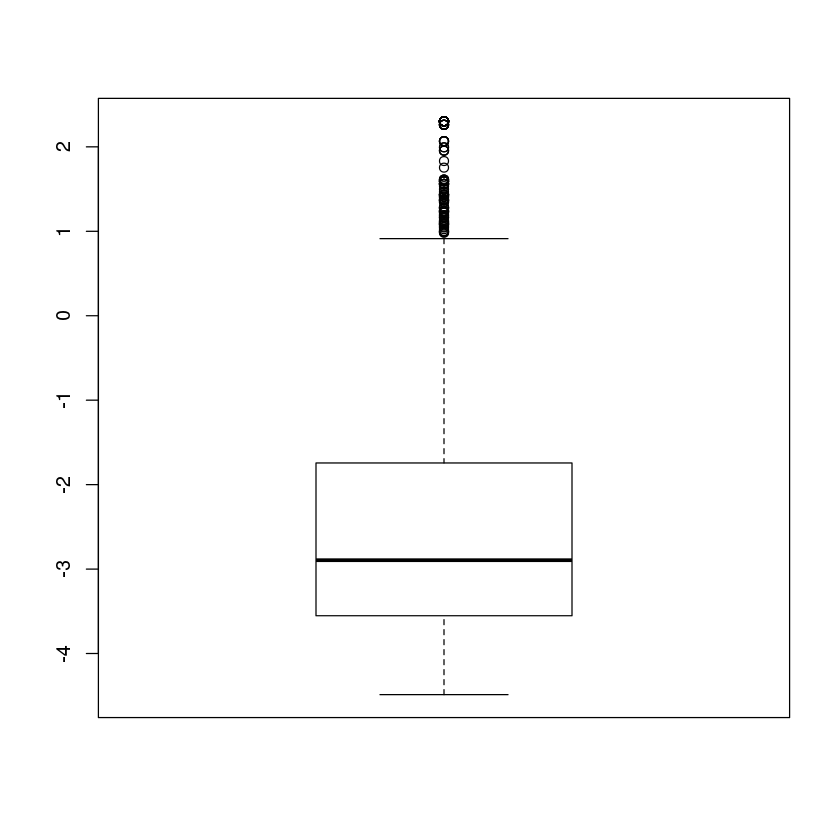

In [69]:
boxplot(log(dispersions(dds)))

# Differential Expression Analysis

We can now conduct a differential expression analysis using the DESeq() function. Keep in mind that to get to this step, we first estimated the size factors and then the dispersion parameters.

In [70]:
ddsDE<-DESeq(dds)

using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


We can get the results for the differential expression analysis using results()

In [71]:
myres<-results(ddsDE)

Let's look at the results for the first four genes

In [72]:
myres[1:4,]

log2 fold change (MAP): trt 8 vs 7 
Wald test p-value: trt 8 vs 7 
DataFrame with 4 rows and 6 columns
          baseMean log2FoldChange     lfcSE       stat    pvalue      padj
         <numeric>      <numeric> <numeric>  <numeric> <numeric> <numeric>
gene0    13.063245     -0.3615907 0.4893341 -0.7389445 0.4599407 0.6219213
gene1   150.403062      0.1396908 0.1986462  0.7032142 0.4819223 0.6403670
gene10    3.611165      0.5993397 0.6889927  0.8698781 0.3843670 0.5526040
gene100  24.170850      0.2231218 0.3708178  0.6017020 0.5473725 0.6965727

Calculate BH adjusted P-values by "hand" using the p.adjust() function

In [90]:
BH=p.adjust(myres$pvalue,"BH")
BH[1:4]

[1] 0.6697729 0.6874771 0.6015045 0.7456457

You can get the descriptions for the columns from the DE analysis

In [73]:
data.frame(desc=mcols(myres)$description)

desc
1 mean of normalized counts for all samples
2        log2 fold change (MAP): trt 8 vs 7
3                standard error: trt 8 vs 7
4                Wald statistic: trt 8 vs 7
5             Wald test p-value: trt 8 vs 7
6                      BH adjusted p-values

We can get summaries of the results:

In [92]:
summary(myres,0.05)


out of 4314 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 615, 14% 
LFC < 0 (down)   : 685, 16% 
outliers [1]     : 8, 0.19% 
low counts [2]   : 501, 12% 
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



You can sort the results by say the unadjusted P-values

In [93]:
myres[order(myres[["pvalue"]])[1:4],]


log2 fold change (MAP): trt 8 vs 7 
Wald test p-value: trt 8 vs 7 
DataFrame with 4 rows and 6 columns
          baseMean log2FoldChange     lfcSE      stat        pvalue          padj
         <numeric>      <numeric> <numeric> <numeric>     <numeric>     <numeric>
gene1209 1110.3199      -3.347061 0.1494578 -22.39469 4.433610e-111 1.686989e-107
gene4405  436.6800       4.443590 0.2145932  20.70704  2.992746e-95  5.693699e-92
gene3312  488.4901       4.659106 0.2363052  19.71648  1.556881e-86  1.974644e-83
gene3317  322.3925       5.043395 0.2598487  19.40897  6.481743e-84  6.165758e-81

To get the list of genes with unadjusted P-values < 0.00001 and absolute log2 FC of more than 4

In [101]:
subset(myres,pvalue<0.00001&abs(log2FoldChange)>4)

log2 fold change (MAP): trt 8 vs 7 
Wald test p-value: trt 8 vs 7 
DataFrame with 24 rows and 6 columns
          baseMean log2FoldChange     lfcSE      stat       pvalue         padj
         <numeric>      <numeric> <numeric> <numeric>    <numeric>    <numeric>
gene1300 175.91020       4.761689 0.4245746  11.21520 3.434060e-29 2.722208e-27
gene2034 128.44386       4.061848 0.3737108  10.86896 1.620365e-27 1.185671e-25
gene2127  82.92247       4.353656 0.3826033  11.37903 5.318545e-30 4.305759e-28
gene2128 120.48719       4.474499 0.3304381  13.54111 8.942850e-42 1.432666e-39
gene2179 436.50102       5.055053 0.2805442  18.01874 1.388728e-72 1.056822e-69
...            ...            ...       ...       ...          ...          ...
gene4405 436.68000       4.443590 0.2145932 20.707043 2.992746e-95 5.693699e-92
gene585   27.68248       5.127633 0.6402242  8.009121 1.155313e-15 3.573956e-14
gene594  121.06565       5.862070 0.4591814 12.766349 2.527334e-37 3.434467e-35
gene595  106.318

To get the list of genes with unadjusted P-values < 0.00001 and upregulated genes with log2 FC of more than 4

In [102]:
subset(myres,pvalue<0.00001&log2FoldChange>4)

log2 fold change (MAP): trt 8 vs 7 
Wald test p-value: trt 8 vs 7 
DataFrame with 24 rows and 6 columns
          baseMean log2FoldChange     lfcSE      stat       pvalue         padj
         <numeric>      <numeric> <numeric> <numeric>    <numeric>    <numeric>
gene1300 175.91020       4.761689 0.4245746  11.21520 3.434060e-29 2.722208e-27
gene2034 128.44386       4.061848 0.3737108  10.86896 1.620365e-27 1.185671e-25
gene2127  82.92247       4.353656 0.3826033  11.37903 5.318545e-30 4.305759e-28
gene2128 120.48719       4.474499 0.3304381  13.54111 8.942850e-42 1.432666e-39
gene2179 436.50102       5.055053 0.2805442  18.01874 1.388728e-72 1.056822e-69
...            ...            ...       ...       ...          ...          ...
gene4405 436.68000       4.443590 0.2145932 20.707043 2.992746e-95 5.693699e-92
gene585   27.68248       5.127633 0.6402242  8.009121 1.155313e-15 3.573956e-14
gene594  121.06565       5.862070 0.4591814 12.766349 2.527334e-37 3.434467e-35
gene595  106.318

The P-values for the four top genes are beyond machine precision. You can use the format.pval() function to properly format the P-values. PLEASE promote ending the practice of publishing P-values below machine precision.  (that would be akin to stating the weight of an object that weighs less than one pound with scale that whose minimum weight spec is 1lbs).

In [50]:
myres$pval=format.pval(myres$pvalue)
myres[order(myres[["pvalue"]])[1:4],]

log2 fold change (MAP): trt 1 vs 0 
Wald test p-value: trt 1 vs 0 
DataFrame with 4 rows and 7 columns
                 baseMean log2FoldChange     lfcSE      stat       pvalue         padj        pval
                <numeric>      <numeric> <numeric> <numeric>    <numeric>    <numeric> <character>
GeneID:12931678 3003.9529       3.860438 0.1874546  20.59399 3.107121e-94 1.143420e-90  < 2.22e-16
GeneID:12930177  753.7226      -2.637364 0.1670864 -15.78443 3.982238e-56 7.327317e-53  < 2.22e-16
GeneID:12931383  440.8970      -3.457843 0.2210372 -15.64372 3.666822e-55 4.497968e-52  < 2.22e-16
GeneID:12933669 5394.4990      -2.084425 0.1391204 -14.98289 9.499917e-51 8.739923e-48  < 2.22e-16

Let's look at a volcano plot

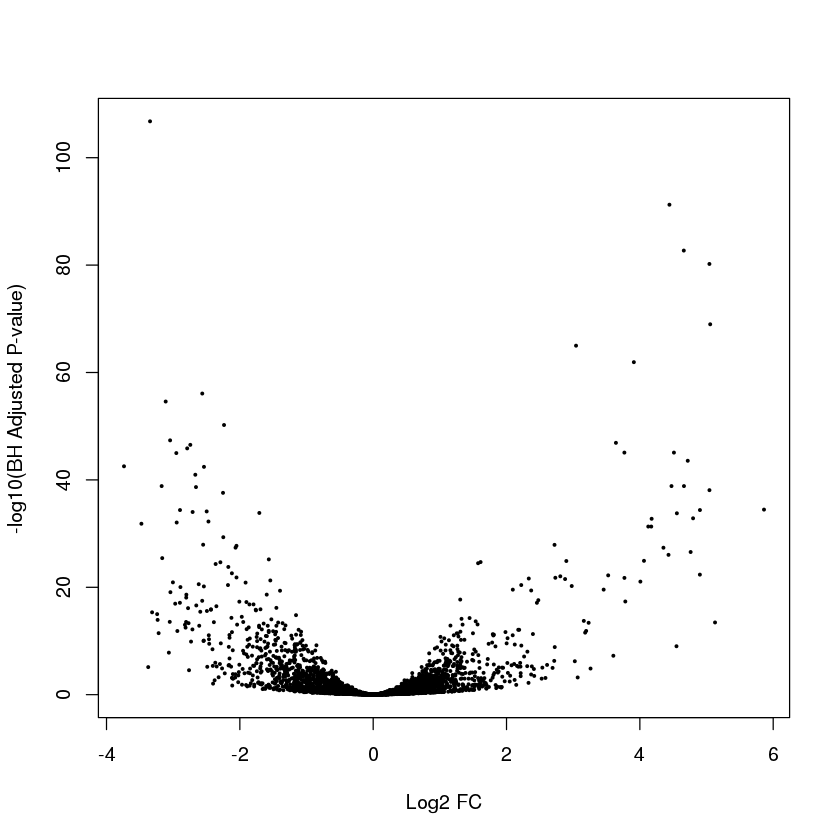

In [103]:
plot(myres$log2FoldChange,-log10(myres$padj),pch=19,cex=0.3,xlab="Log2 FC",ylab="-log10(BH Adjusted P-value)")

Extract results for genes GeneID:12932226 and GeneID:12930116

In [52]:
myres[c("GeneID:12932226","GeneID:12930116"),]

log2 fold change (MAP): trt 1 vs 0 
Wald test p-value: trt 1 vs 0 
DataFrame with 2 rows and 7 columns
                  baseMean log2FoldChange     lfcSE      stat       pvalue         padj        pval
                 <numeric>      <numeric> <numeric> <numeric>    <numeric>    <numeric> <character>
GeneID:12932226 1276.69035      4.4435720 0.6376555 6.9686095 3.200888e-12 8.413761e-11  3.2009e-12
GeneID:12930116   35.65951      0.3172361 0.3883336 0.8169164 4.139762e-01 6.333378e-01  0.41397621

Exercise: Annotate the hits with adjusted P-values < 0.05 and absolute log2 FC greater than 2 in red

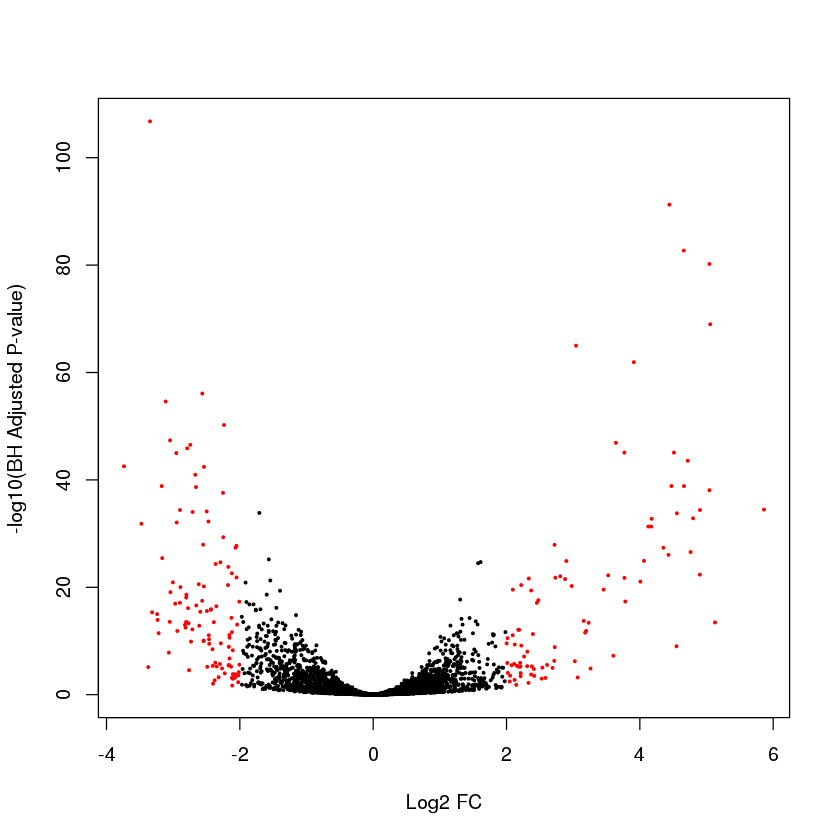

In [104]:
plot(myres$log2FoldChange,-log10(myres$padj),pch=19,cex=0.3,xlab="Log2 FC",ylab="-log10(BH Adjusted P-value)",col=ifelse(myres$padj<0.05&abs(myres$log2FoldChange)>2,"red","black"))

# Converting/Normalizing Counts to "Expressions" 

## Normalized Counts

We have already shown how to "normalize" the counts using the estimated size factors

In [105]:
head(counts(dds,normalize=TRUE),3)

7A_E       7B_E       7C_E       8A_E       8B_E       8C_E
gene0   11.046885  13.949554  19.331230  19.198464   6.946801   7.906535
gene1  132.562617 138.333073 157.702138 176.443026 142.409428 154.968093
gene10   3.682295   2.324926   2.034866   5.485275   2.605051   5.534575

Plot the counts stratified by treatment for the 2nd gene

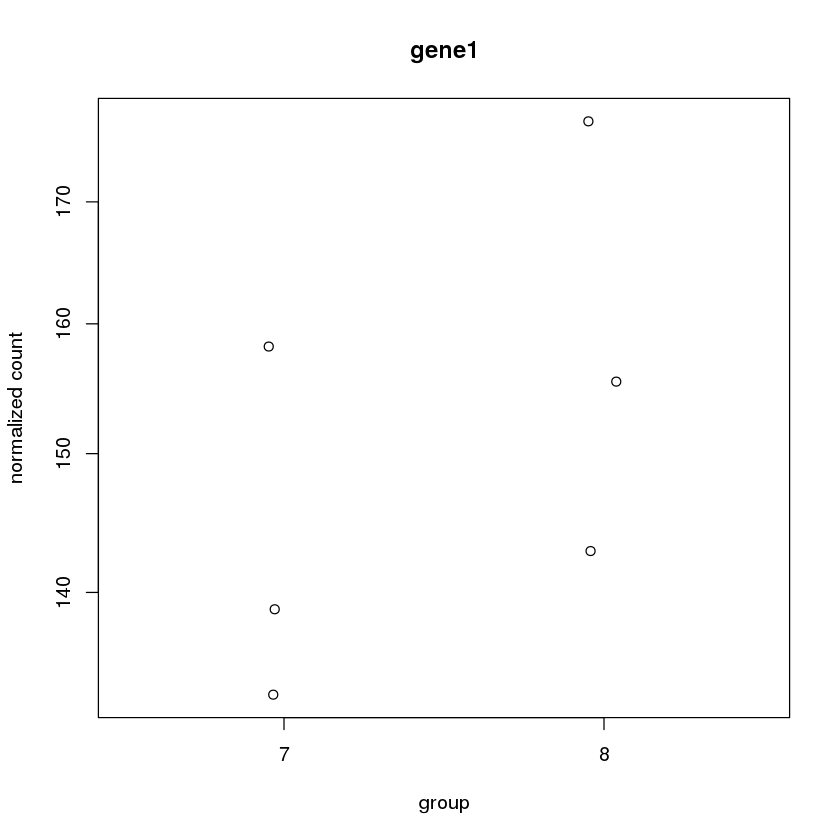

In [106]:
 plotCounts(dds, 2,intgroup="trt")

Or alternatively (better)

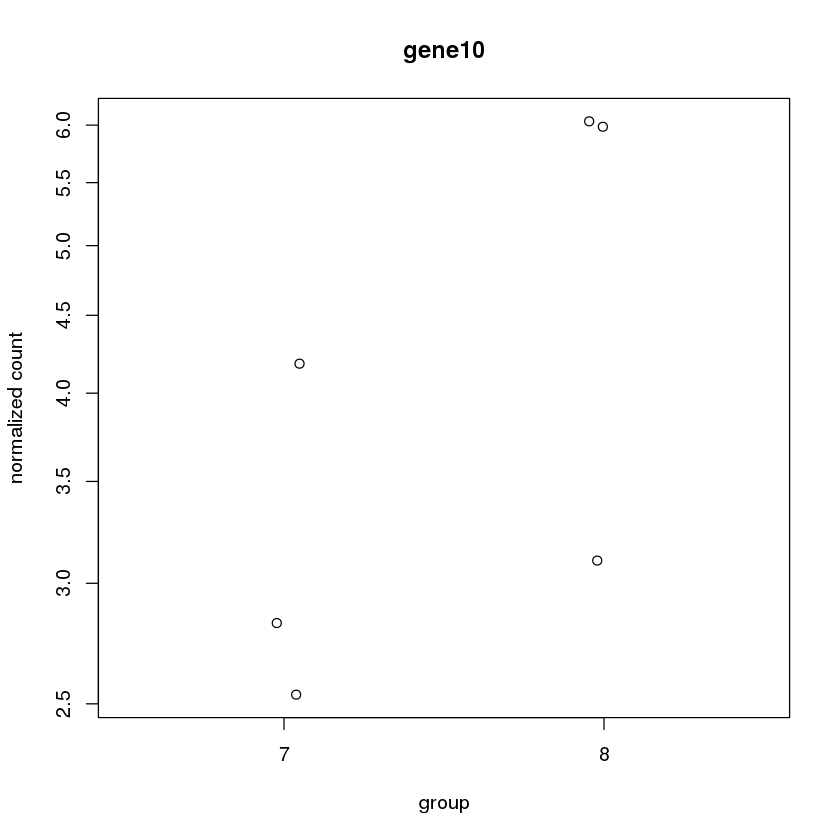

In [107]:
 plotCounts(dds, "gene10",intgroup="trt")

Now get this plot for the top hit

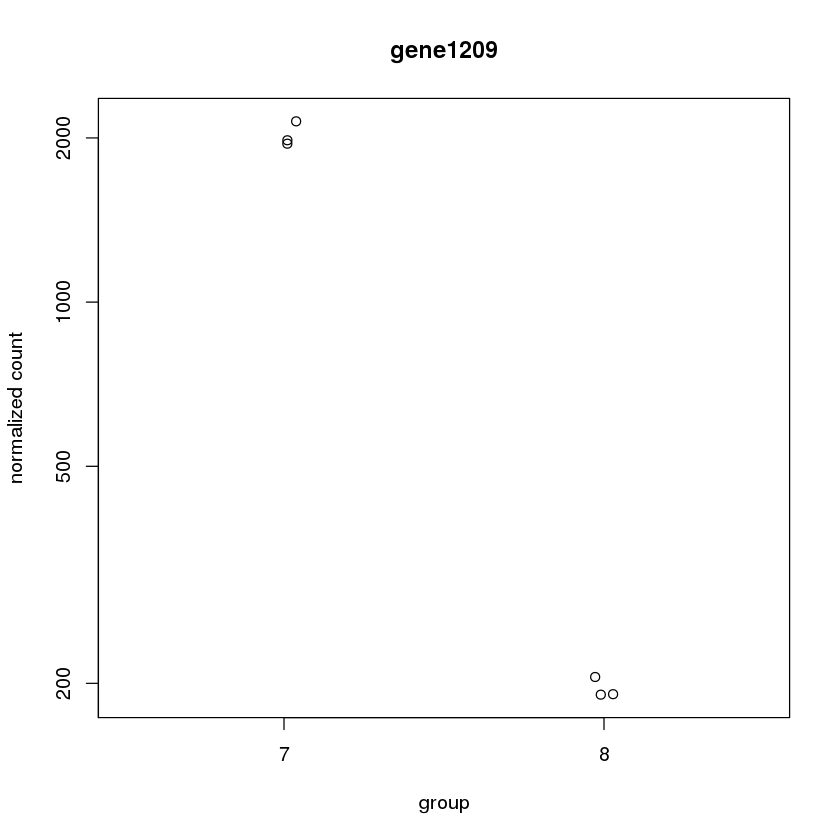

In [109]:
plotCounts(dds, "gene1209",intgroup="trt")

## FPM

Another approach is to FPM: fragments per million mapped fragments

In [110]:
head(fpm(dds),3)

7A_E      7B_E       7C_E      8A_E      8B_E       8C_E
gene0   7.563666  9.551087  13.235854  13.14495  4.756389   5.413507
gene1  90.763986 94.714946 107.976706 120.80836 97.505976 106.104739
gene10  2.521222  1.591848   1.393248   3.75570  1.783646   3.789455

Let's calculate the FPM manually. For gene $i$ sample $j$, the FPM is defined as $\frac{K_{ij}}{D_j}\times 10^{6}$ where $D_j=\sum_{i=1} K_{ij}$ is the read depth for sample $j$. First get the read depth for each sample

In [111]:
D=colSums(counts(dds))
D

7A_E    7B_E    7C_E    8A_E    8B_E    8C_E 
1224153 1294576 1493765 1492923 1581586 1736478

By default, the fpm() function uses a robust approach. We will disable this right now as to replicate the standard FPM. Let's look at gene 1

In [112]:
fpm1<-fpm(dds,robust=FALSE)[1,]
fpm1

7A_E      7B_E      7C_E      8A_E      8B_E      8C_E 
 7.352022  9.269444 12.719538 14.066365  5.058214  5.758783

Now get the raw counts for gene 1

In [114]:
cnt1<-counts(dds)[1,]
cnt1

7A_E 7B_E 7C_E 8A_E 8B_E 8C_E 
   9   12   19   21    8   10

Now calculate the FPM for gene 1

In [115]:
myfpm1<-cnt1/D*1e6
myfpm1

7A_E      7B_E      7C_E      8A_E      8B_E      8C_E 
 7.352022  9.269444 12.719538 14.066365  5.058214  5.758783

This is how you check if two numeric columns are "equal"

In [116]:
min(abs(fpm1-myfpm1))

[1] 0

## FPKM

To calculate the FPKM (fragments per kilobase per million mapped fragments) we need to add annotation to assign the feature lengths. More specifically, for gene $i$ sample $j$, the FPKM is defined as $\frac{K_{ij}}{\ell_i D_j}\times 10^3 \times 10^{6}$ where $\ell_i$ is the "length" of gene $i$ (fragments for each $10^3$ bases in the gene for every  $\frac{D_j}{10^6}$ fragments. More on this later.

## Regularized log transformation

The regularized log transform can be obtained using the rlog() function. Note that an important argument for this function is blind (TRUE by default). The default "blinds" the normalization to the design. This is very important so as to not bias the analyses (e.g. class discovery 

In [117]:
rld<-rlog(dds,blind=TRUE)

Hierarchical clustering using rlog transformation

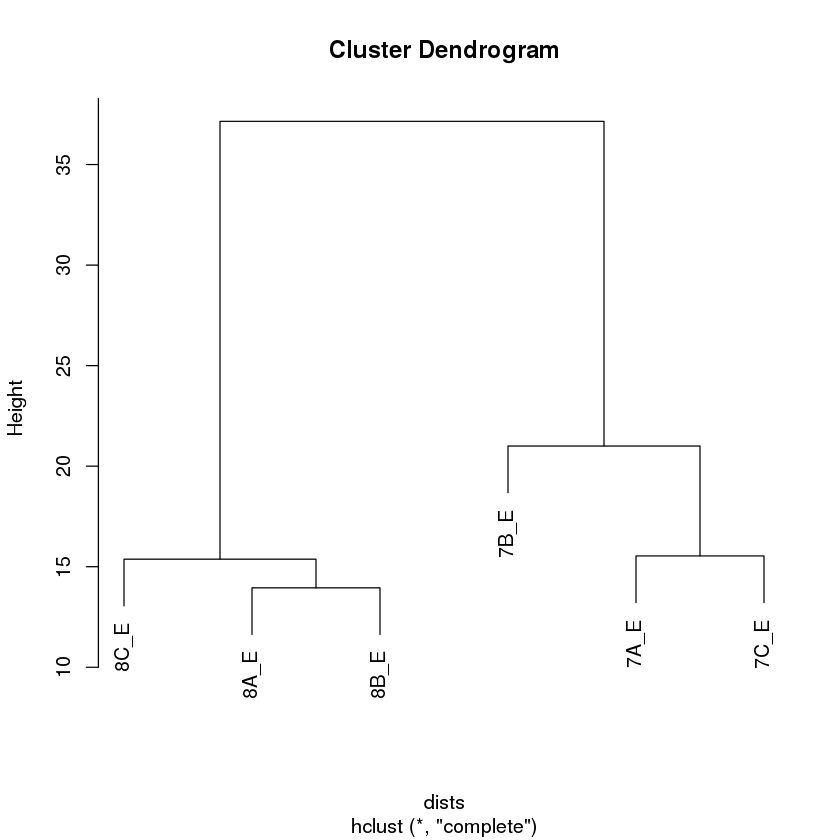

In [118]:
dists<-dist(t(assay(rld)))
plot(hclust(dists))


PC Analysis using the rlog transformation

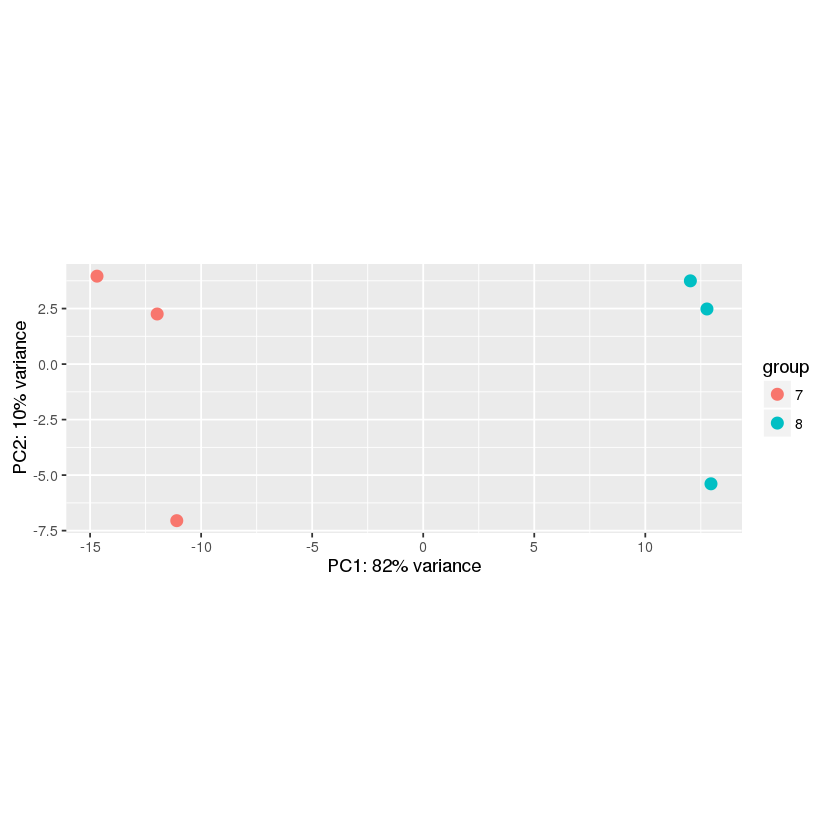

In [119]:
 plotPCA(rld,intgroup="trt")

In [120]:
sessionInfo()

R version 3.3.1 (2016-06-21)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 8 (jessie)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C               LC_TIME=en_US.UTF-8       
 [4] LC_COLLATE=en_US.UTF-8     LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                  LC_ADDRESS=C              
[10] LC_TELEPHONE=C             LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] tools     parallel  stats4    stats     graphics  grDevices utils     datasets  methods  
[10] base     

other attached packages:
[1] qvalue_2.4.2               DESeq2_1.12.3              SummarizedExperiment_1.2.3
[4] Biobase_2.32.0             GenomicRanges_1.24.2       GenomeInfoDb_1.8.3        
[7] IRanges_2.6.1              S4Vectors_0.10.2           BiocGenerics_0.18.0       

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.2-3         genefilter_1.54.2    locfit_1.5-9.1       repr_0.7